In [1]:
def plotly_template(template_specs):
    import plotly.graph_objects as go
    fig_template=go.layout.Template()

    # Layout
    fig_template.layout = (go.Layout(# general
                                    font_family=template_specs['font'],
                                    font_size=template_specs['axes_font_size'],
                                    plot_bgcolor=template_specs['bg_col'],

                                    # x axis
                                    xaxis_visible=True,
                                    xaxis_linewidth=template_specs['axes_width'],
                                    xaxis_color= template_specs['axes_color'],
                                    xaxis_showgrid=False,
                                    xaxis_ticks="outside",
                                    xaxis_ticklen=0,
                                    xaxis_tickwidth = template_specs['axes_width'],
                                    xaxis_title_font_family=template_specs['font'],
                                    xaxis_title_font_size=template_specs['title_font_size'],
                                    xaxis_tickfont_family=template_specs['font'],
                                    xaxis_tickfont_size=template_specs['axes_font_size'],
                                    xaxis_zeroline=False,
                                    xaxis_zerolinecolor=template_specs['axes_color'],
                                    xaxis_zerolinewidth=template_specs['axes_width'],
                                    xaxis_range=[0,1],
                                    xaxis_hoverformat = '.1f',
                                    
                                    # y axis
                                    yaxis_visible=False,
                                    yaxis_linewidth=0,
                                    yaxis_color= template_specs['axes_color'],
                                    yaxis_showgrid=False,
                                    yaxis_ticks="outside",
                                    yaxis_ticklen=0,
                                    yaxis_tickwidth = template_specs['axes_width'],
                                    yaxis_tickfont_family=template_specs['font'],
                                    yaxis_tickfont_size=template_specs['axes_font_size'],
                                    yaxis_title_font_family=template_specs['font'],
                                    yaxis_title_font_size=template_specs['title_font_size'],
                                    yaxis_zeroline=False,
                                    yaxis_zerolinecolor=template_specs['axes_color'],
                                    yaxis_zerolinewidth=template_specs['axes_width'],
                                    yaxis_hoverformat = '.1f',
                                    ))

    # Annotations
    fig_template.layout.annotationdefaults = go.layout.Annotation(
                                    font_color=template_specs['axes_color'],
                                    font_family=template_specs['font'],
                                    font_size=template_specs['title_font_size'])

    return fig_template


In [2]:
# General imports
# ---------------
import os, sys, json, glob, ipdb, h5py, scipy.io
import numpy as np
import pandas as pd
opj = os.path.join
deb = ipdb.set_trace

# MRI imports
# -----------
import nibabel as nb
import cortex

# Plotly imports
# --------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Get inputs
# ----------
subject = 'sub-01'
task = 'pMF'
preproc = 'fmriprep_dct'
regist_type = 'T1w'
sub_task = 'sac'

# Define analysis parameters
# --------------------------
with open('projects/PredictEye/mri_analysis/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define folders and settings
# ---------------------------
base_dir = analysis_info['base_dir']
rois = ['sPCS']
rois_mask_dir = "{}/pp_data/{}/gauss/roi_masks/".format(base_dir, subject)
deriv_dir = "{}/pp_data/{}/gauss/fit/{}".format(base_dir, subject,task)
h5_dir = "{}/pp_data/{}/gauss/h5/{}{}".format(base_dir, subject, task, sub_task)

rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
    amp_idx, baseline_idx, cov_idx, x_idx, y_idx, hemi_idx = 0,1,2,3,4,5,6,7,8,9,10

# general figure settings
template_specs = dict(  axes_color="rgba(0, 0, 0, 1)",          # figure axes color
                        axes_width=2,                           # figureaxes line width
                        axes_font_size=15,                      # font size of axes
                        bg_col="rgba(255, 255, 255, 1)",        # figure background color
                        font='Helvetica',                       # general font used
                        title_font_size=18,                     # font size of titles
                        plot_width=1.5,                         # plot line width
                        )

fig_template = plotly_template(template_specs)

In [3]:
# Initialize data
# ---------------
df_raw = pd.DataFrame()
for roi_num, roi in enumerate(rois):
    
    # load h5 file
    h5_file = h5py.File("{}/{}_{}_{}.h5".format(h5_dir, roi, preproc, regist_type),'r')

    # load deriv data
    deriv_data = h5_file['{}{}/derivatives'.format(task, sub_task)]
    
    # load time course data
    tc_data = h5_file['{}{}/time_course'.format(task, sub_task)]

    # load model time course data
    tc_model_data = h5_file['{}{}/time_course_model'.format(task, sub_task)]

    # load coordinates data
    coord_data = h5_file['{}{}/coord'.format(task, sub_task)]

    # define dataframe
    df_roi = pd.DataFrame(deriv_data,columns = ['rsq','ecc','polar_real','polar_imag','size','amp','baseline','cov','x','y','hemi'])
    df_roi['roi']=[roi for x in range(df_roi.shape[0])]
    df_roi['subject']=[subject for x in range(df_roi.shape[0])]
    df_roi['task']=[task for x in range(df_roi.shape[0])]
    df_roi['sub_task']=[sub_task for x in range(df_roi.shape[0])]
    df_roi['signal_tc']=pd.Series(data=tc_data)
    df_roi['model_tc']=pd.Series(data=tc_model_data)
    df_roi['voxel_coords']=pd.Series(data=coord_data)
    df_raw = pd.concat([df_raw, df_roi],ignore_index=True, axis = 0)


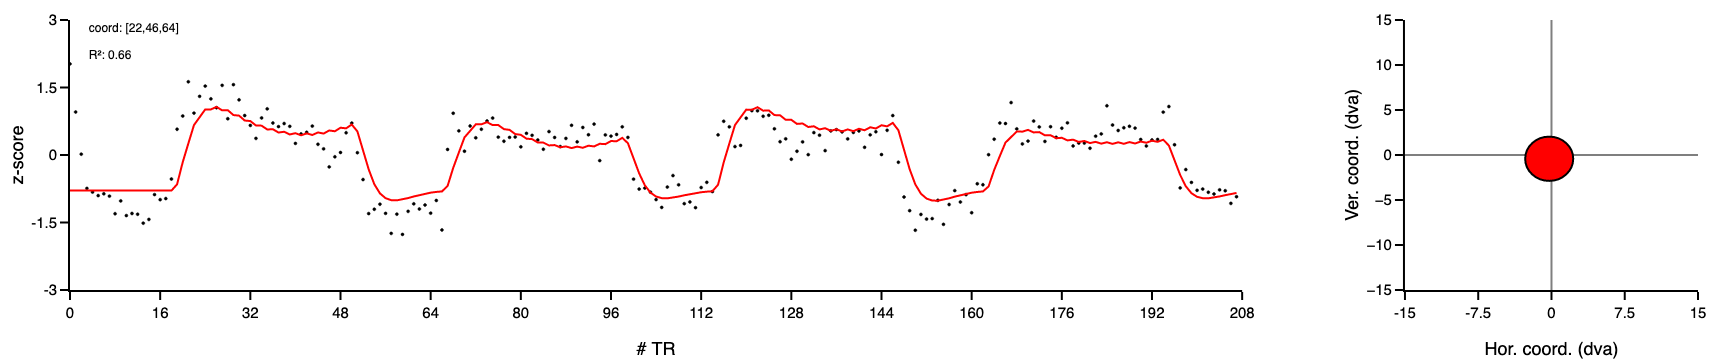

In [45]:
df = df_raw
df_plot = df[df.rsq>0.6]
numplot = 0

fig_height, fig_width = 250,1000
rows, cols = 1, 2

x_label_tc, y_label_tc = '# TR', 'z-score'
x_range_tc, y_range_tc = [0,analysis_info['TRs']], [-3,3]
x_tickvals_tc = np.linspace(x_range_tc[0],x_range_tc[1],14)
y_tickvals_tc = np.linspace(y_range_tc[0],y_range_tc[1],5)
x_ticktexts_tc = ['{:g}'.format(x) for x in x_tickvals_tc]
y_ticktexts_tc = ['{:g}'.format(x) for x in y_tickvals_tc]


x_label_map, y_label_map = 'Hor. coord. (dva)', 'Ver. coord. (dva)',
y_range_map, x_range_map = [-15,15], [-15,15]
x_tickvals_map = np.linspace(x_range_map[0],x_range_map[1],5)
y_tickvals_map = np.linspace(y_range_map[0],y_range_map[1],5)
x_ticktexts_map = ['{:g}'.format(x) for x in x_tickvals_map]
y_ticktexts_map = ['{:g}'.format(x) for x in y_tickvals_map]


# subplot settings
row_heights = [4]
column_widths = [4,1]

sb_specs = [[{},{}]]
fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.1, horizontal_spacing=0.5/5,
                    column_widths=column_widths, row_heights=row_heights, shared_yaxes=False)

# draw data timecourse
fig.append_trace(go.Scatter(y=df_plot.signal_tc.values[numplot],
                            mode='markers', name='data',showlegend=False,
                            marker_symbol='circle', marker_size=3, marker_color='black',
                            marker_line_color='black',marker_line_width = 0.5),row=1, col=1)
# draw model timecourse
fig.append_trace(go.Scatter(y=df_plot.model_tc.values[numplot],
                            mode='lines', name='model',showlegend=False,
                            line_color='red'),row=1, col=1)

# draw model map
x_model, y_model = df_plot.x.values[numplot], df_plot.y.values[numplot]
size_model = df_plot['size'].values[numplot]
fig.add_shape(type="circle", x0=x_model-size_model/2, y0=y_model-size_model/2, x1=x_model+size_model/2, y1=y_model+size_model/2, fillcolor= 'red', row=1, col=2) 

# add annotations
fig.add_annotation( xref="paper", yref="paper", x=0.01, y=1, showarrow=False, font_size=12,
                    text="coord: [{xcoord:0.0f},{ycoord:0.0f},{zcoord:0.0f}]".format(  xcoord=df_plot.voxel_coords.values[numplot][0],
                                                                        ycoord=df_plot.voxel_coords.values[numplot][1],
                                                                        zcoord=df_plot.voxel_coords.values[numplot][2],))
fig.add_annotation( xref="paper", yref="paper", x=0.01, y=0.9, showarrow=False, font_size=12,
                    text="R\u00b2: {:1.2f}".format(df_plot.rsq.values[numplot]))


# figure layout
fig.layout.update(  # figure settings
                    template=fig_template, width=fig_width, height=fig_height, margin_l=70, margin_r=20, margin_t=20, margin_b=70,
                    
                    # timecourse
                    yaxis_visible=True, yaxis1_linewidth=template_specs['axes_width'], yaxis1_title_text=y_label_tc, 
                    yaxis1_range=y_range_tc, yaxis1_ticklen=8, yaxis1_tickvals=y_tickvals_tc, yaxis1_ticktext=y_ticktexts_tc,
                    xaxis1_visible=True, xaxis1_linewidth=template_specs['axes_width'], xaxis1_title_text=x_label_tc, 
                    xaxis1_range=x_range_tc, xaxis1_ticklen=8, xaxis1_tickvals=x_tickvals_tc, xaxis1_ticktext=x_ticktexts_tc,

                    # map
                    yaxis2_visible=True, yaxis2_linewidth=template_specs['axes_width'], yaxis2_title_text=y_label_map, 
                    yaxis2_range=y_range_map, yaxis2_ticklen=8, yaxis2_ticktext=y_ticktexts_map,
                    yaxis2_zeroline=True, yaxis2_zerolinecolor='rgba(0,0,0,0.5)',
                    xaxis2_visible=True, xaxis2_linewidth=template_specs['axes_width'], xaxis2_title_text=x_label_map, 
                    xaxis2_range=x_range_map, xaxis2_ticklen=8, xaxis2_tickvals=x_tickvals_map, xaxis2_ticktext=x_ticktexts_map,
                    xaxis2_zeroline=True, xaxis2_zerolinecolor='rgba(0,0,0,0.5)',
                    )

fig.show()

In [4]:
import pandas as pd
subject = "sub-01"
task = 'pMF'
preproc = 'fmriprep_dct'
sub_task = 'sac'
regist_type = 'T1w'
roi = "V3"

df_name = "apps/data/{}/{}{}/{}_{}_{}.gz".format(subject,task,sub_task,roi,preproc,regist_type)
df = pd.read_pickle(df_name,compression='gzip')

In [5]:
df

AttributeError: 'DataFrame' object has no attribute '_data'